170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step
Training CNN...
Epoch 1/10
782/782 - 29s - 37ms/step - accuracy: 0.3992 - loss: 1.6482 - val_accuracy: 0.5334 - val_loss: 1.3023
Epoch 2/10
782/782 - 21s - 27ms/step - accuracy: 0.5266 - loss: 1.3173 - val_accuracy: 0.6081 - val_loss: 1.1099
Epoch 3/10
782/782 - 41s - 53ms/step - accuracy: 0.5774 - loss: 1.1899 - val_accuracy: 0.6473 - val_loss: 1.0134
Epoch 4/10
782/782 - 41s - 53ms/step - accuracy: 0.6089 - loss: 1.1014 - val_accuracy: 0.6619 - val_loss: 0.9678
Epoch 5/10
782/782 - 41s - 52ms/step - accuracy: 0.6325 - loss: 1.0423 - val_accuracy: 0.6632 - val_loss: 0.9469
Epoch 6/10
782/782 - 41s - 53ms/step - accuracy: 0.6483 - loss: 0.9901 - val_accuracy: 0.6870 - val_loss: 0.8910
Epoch 7/10
782/782 - 43s - 55ms/step - accuracy: 0.6662 - loss: 0.9405 - val_accuracy: 0.6894 - val_loss: 0.8898
Epoch 8/10
782/782 - 22s - 28ms/step - accuracy: 0.6776 - loss: 0.9090 - val_accuracy: 0.6974 - val_loss: 0.8622
Epoch 9/10
782/782 - 22s -

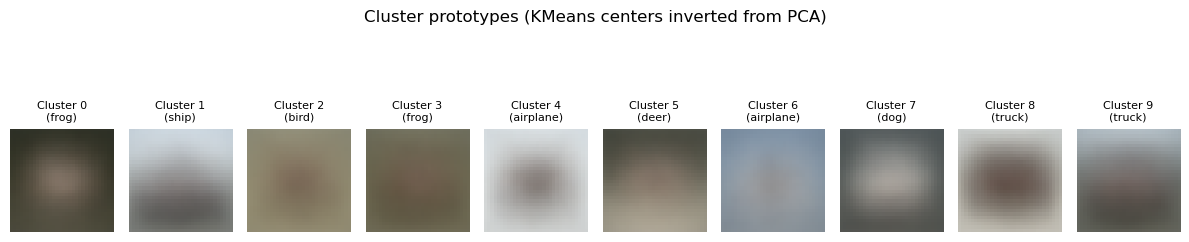

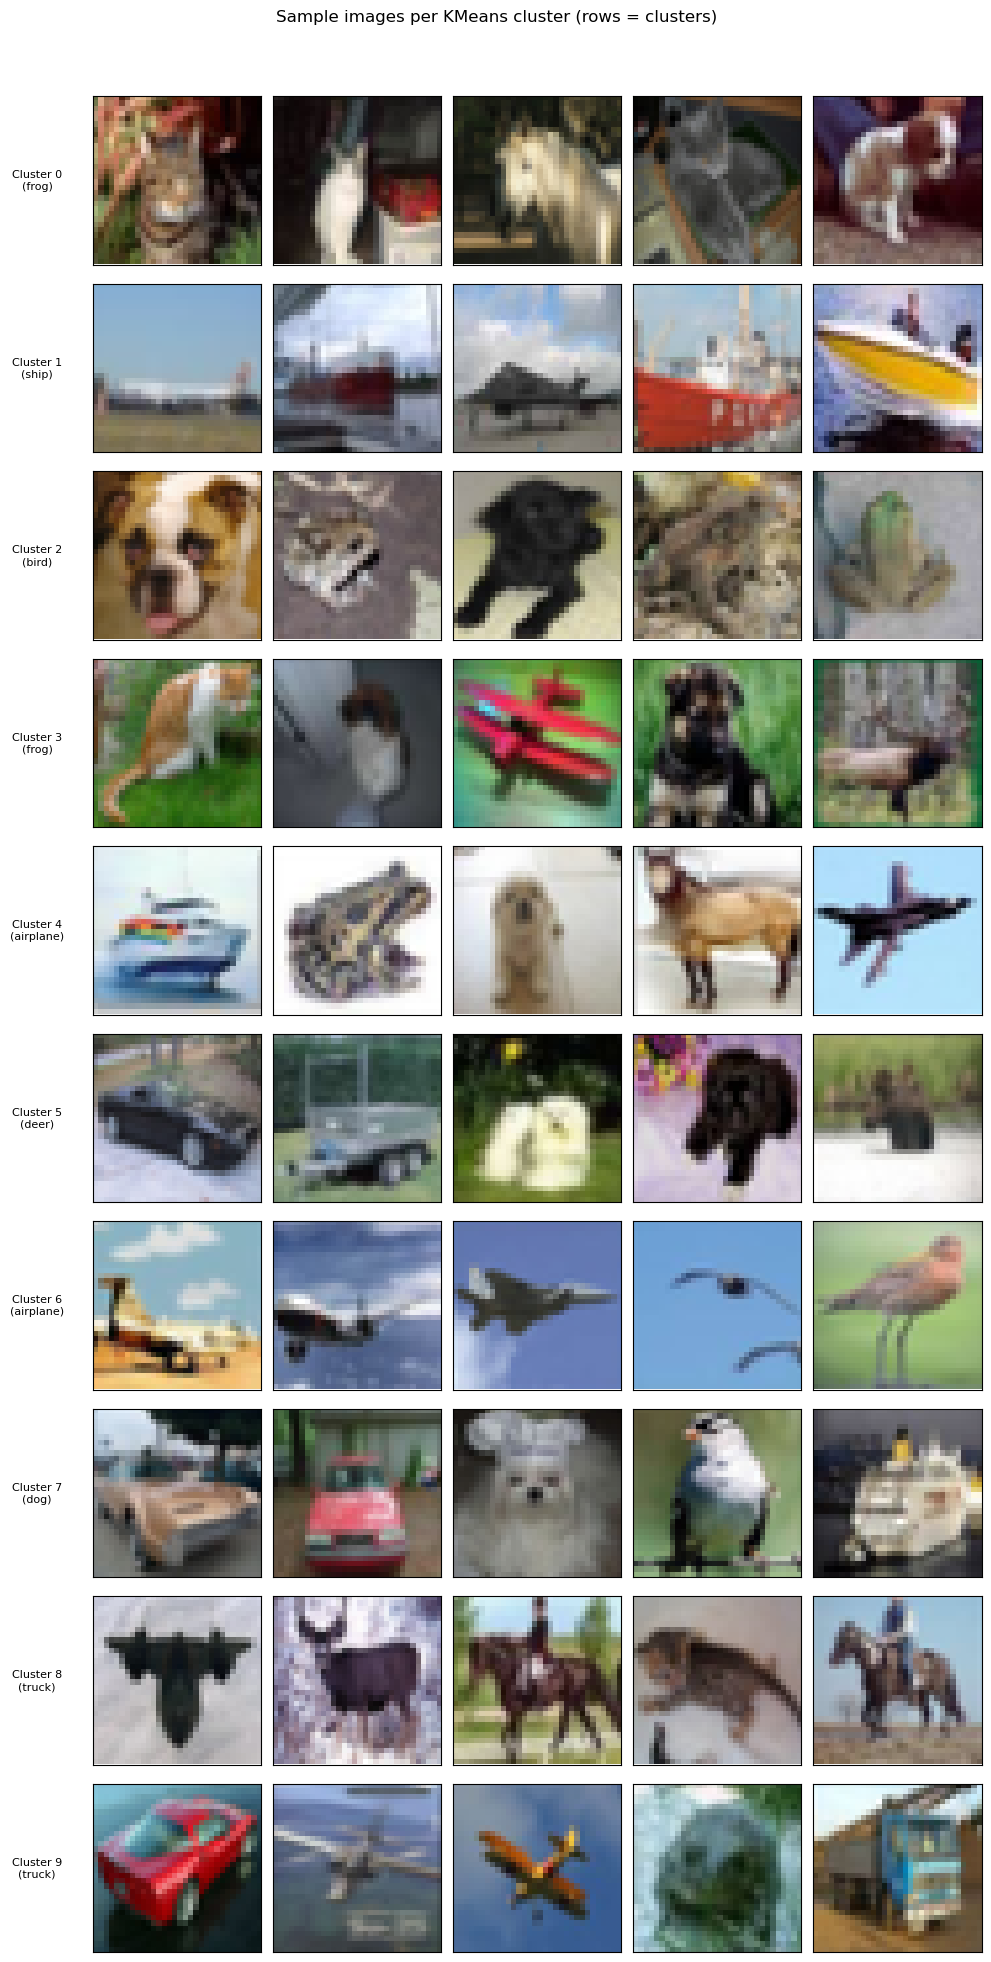

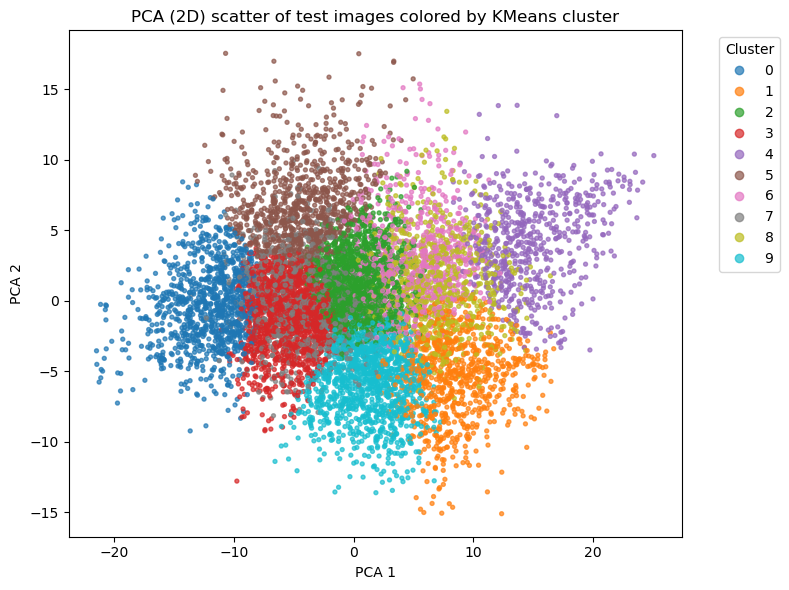

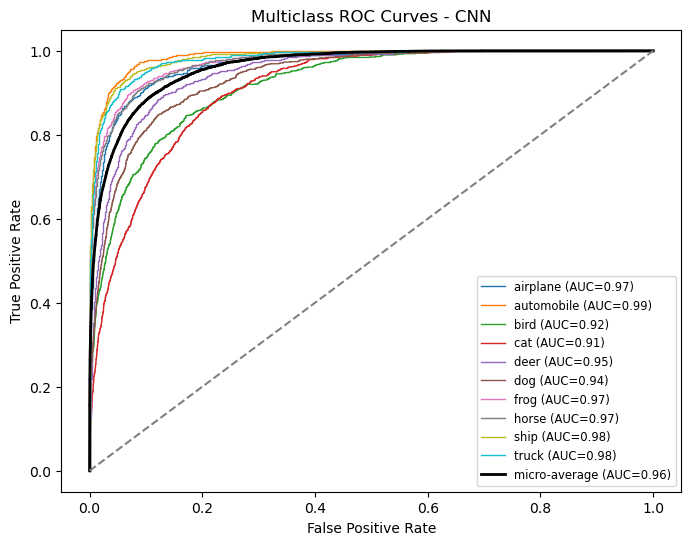

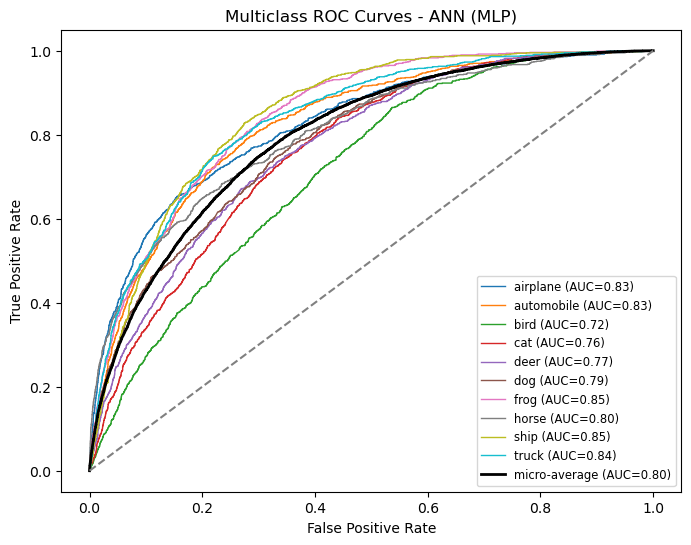


--- Supervised CNN ---
Accuracy: 0.7112
              precision    recall  f1-score   support

    airplane       0.77      0.73      0.75      1000
  automobile       0.85      0.82      0.84      1000
        bird       0.66      0.46      0.54      1000
         cat       0.49      0.55      0.52      1000
        deer       0.58      0.76      0.66      1000
         dog       0.67      0.55      0.60      1000
        frog       0.78      0.79      0.78      1000
       horse       0.78      0.76      0.77      1000
        ship       0.79      0.86      0.82      1000
       truck       0.78      0.83      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000


--- Supervised ANN (MLP) ---
Accuracy: 0.3492
              precision    recall  f1-score   support

    airplane       0.56      0.24      0.34      1000
  automobile       0.48      0.35      0.40 

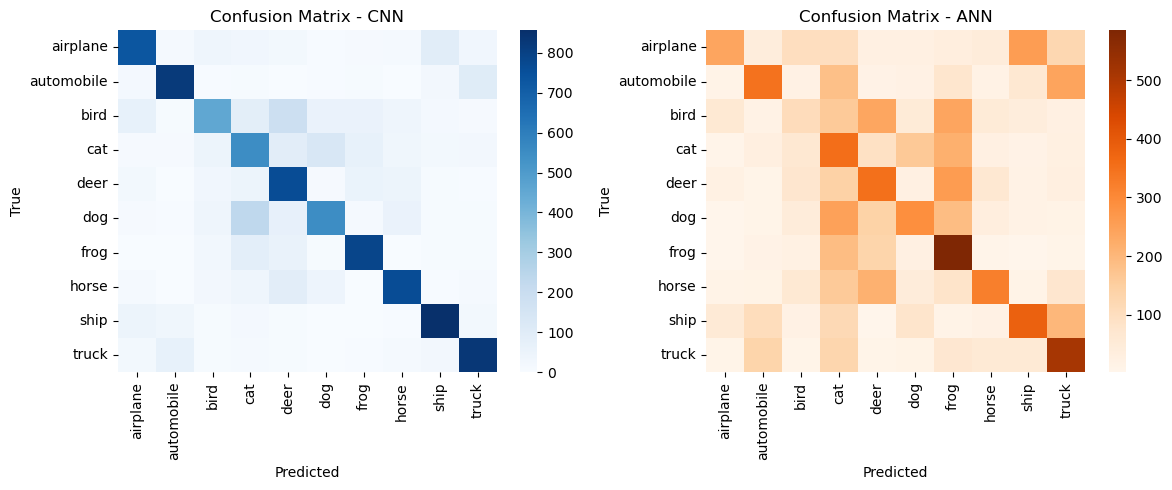


Comparison:
            method  accuracy  roc_auc_micro  roc_auc_macro       ARI      NMI
0              CNN    0.7112       0.961689       0.957991       NaN      NaN
1        ANN (MLP)    0.3492       0.797248       0.802834       NaN      NaN
2  KMeans (mapped)    0.2226            NaN            NaN  0.043011  0.08505

Best method for image classification on CIFAR-10 (by accuracy): CNN


In [1]:
# CIFAR-10: CNN, ANN (MLP), KMeans clustering with image-cluster outputs and cluster prototypes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd

from tensorflow.keras import Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    adjusted_rand_score, normalized_mutual_info_score, silhouette_score
)

# -------------------------
# Load and prepare data
# -------------------------
np.random.seed(42)
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.ravel(); y_test = y_test.ravel()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# -------------------------
# Supervised model 1: CNN
# -------------------------
cnn = Sequential([
    Input(shape=(32,32,3)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
print("Training CNN...")
cnn.fit(X_train, y_train_cat, epochs=10, batch_size=64, validation_data=(X_test, y_test_cat), verbose=2)
y_pred_proba_cnn = cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)
acc_cnn = accuracy_score(y_test, y_pred_cnn)

# -------------------------
# Supervised model 2: ANN (MLP)
# -------------------------
ann = Sequential([
    Input(shape=(32,32,3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
ann.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
print("Training ANN (MLP)...")
ann.fit(X_train, y_train_cat, epochs=10, batch_size=128, validation_data=(X_test, y_test_cat), verbose=2)
y_pred_proba_ann = ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_proba_ann, axis=1)
acc_ann = accuracy_score(y_test, y_pred_ann)

# -------------------------
# Unsupervised: PCA + KMeans
# -------------------------
# Flatten images for PCA/KMeans
X_flat = X_test.reshape(X_test.shape[0], -1)

# PCA to reduce dimensionality before clustering (improves speed & quality)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_flat)

# KMeans clustering
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Clustering metrics
ari = adjusted_rand_score(y_test, cluster_labels)
nmi = normalized_mutual_info_score(y_test, cluster_labels)
sil = silhouette_score(X_pca, cluster_labels)

# Map clusters -> majority label and compute clustering-based accuracy
cluster_to_labels = defaultdict(list)
for cl, true in zip(cluster_labels, y_test):
    cluster_to_labels[cl].append(true)
cluster_majority = {cl: Counter(lbls).most_common(1)[0][0] for cl, lbls in cluster_to_labels.items()}
cluster_mapped_pred = np.array([cluster_majority[cl] for cl in cluster_labels])
acc_kmeans_mapped = accuracy_score(y_test, cluster_mapped_pred)

# -------------------------
# Cluster prototypes (visualize cluster centers)
# -------------------------
# KMeans cluster centers are in PCA space; invert PCA to image space
centers_pca = kmeans.cluster_centers_                # shape (k, n_components)
centers_flat = pca.inverse_transform(centers_pca)    # shape (k, 32*32*3)
centers_images = centers_flat.reshape((k, 32, 32, 3))
# Clip values to [0,1] for display
centers_images = np.clip(centers_images, 0.0, 1.0)

# -------------------------
# Visualizations: clusters and prototypes
# -------------------------
# 1) Show cluster prototypes (one image per cluster)
plt.figure(figsize=(12, 3))
for cl in range(k):
    ax = plt.subplot(1, k, cl+1)
    ax.imshow(centers_images[cl])
    ax.set_title(f"Cluster {cl}\n({class_names[cluster_majority.get(cl,0)]})", fontsize=8)
    ax.axis('off')
plt.suptitle("Cluster prototypes (KMeans centers inverted from PCA)")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# 2) Show sample images per cluster (rows = clusters)
samples_per_cluster = 5
plt.figure(figsize=(samples_per_cluster * 2, k * 2))
for cl in range(k):
    idxs = np.where(cluster_labels == cl)[0]
    if len(idxs) == 0:
        # empty cluster
        for i in range(samples_per_cluster):
            ax = plt.subplot(k, samples_per_cluster, cl * samples_per_cluster + i + 1)
            ax.axis('off')
        continue
    chosen = np.random.choice(idxs, min(samples_per_cluster, len(idxs)), replace=False)
    for i, idx in enumerate(chosen):
        ax = plt.subplot(k, samples_per_cluster, cl * samples_per_cluster + i + 1)
        ax.imshow(X_test[idx])
        ax.set_xticks([]); ax.set_yticks([])
        if i == 0:
            ax.set_ylabel(f"Cluster {cl}\n({class_names[cluster_majority.get(cl,0)]})", rotation=0, labelpad=40, va='center', fontsize=8)
plt.suptitle("Sample images per KMeans cluster (rows = clusters)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3) PCA scatter colored by cluster (first two PCA components)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', s=8, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("PCA (2D) scatter of test images colored by KMeans cluster")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

# -------------------------
# ROC / AUC: multiclass (one-vs-rest) for CNN and ANN
# -------------------------
y_test_bin = label_binarize(y_test, classes=range(10))

def compute_plot_roc(y_true_bin, y_score, model_name, plot=True):
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(y_true_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc_micro = roc_auc_score(y_true_bin, y_score, average='micro', multi_class='ovr')
    roc_auc_macro = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
    if plot:
        plt.figure(figsize=(8,6))
        for i in range(y_true_bin.shape[1]):
            plt.plot(fpr[i], tpr[i], lw=1, label=f"{class_names[i]} (AUC={roc_auc[i]:.2f})")
        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        plt.plot(fpr_micro, tpr_micro, color='k', lw=2, label=f"micro-average (AUC={roc_auc_micro:.2f})")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title(f"Multiclass ROC Curves - {model_name}")
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right', fontsize='small')
        plt.show()
    return roc_auc_micro, roc_auc_macro

roc_cnn_micro, roc_cnn_macro = compute_plot_roc(y_test_bin, y_pred_proba_cnn, "CNN")
roc_ann_micro, roc_ann_macro = compute_plot_roc(y_test_bin, y_pred_proba_ann, "ANN (MLP)")

# -------------------------
# Metrics: classification reports & confusion matrices
# -------------------------
print("\n--- Supervised CNN ---")
print(f"Accuracy: {acc_cnn:.4f}")
print(classification_report(y_test, y_pred_cnn, target_names=class_names))

print("\n--- Supervised ANN (MLP) ---")
print(f"Accuracy: {acc_ann:.4f}")
print(classification_report(y_test, y_pred_ann, target_names=class_names))

print("\n--- KMeans (mapped) ---")
print(f"Mapped accuracy: {acc_kmeans_mapped:.4f}")
print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}, Silhouette: {sil:.4f}")

# Confusion matrix for CNN and ANN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_ann = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_cnn, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - CNN'); plt.xlabel('Predicted'); plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_ann, annot=False, cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ANN'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

# -------------------------
# Final comparison table & verdict
# -------------------------
results = pd.DataFrame({
    'method': ['CNN', 'ANN (MLP)', 'KMeans (mapped)'],
    'accuracy': [acc_cnn, acc_ann, acc_kmeans_mapped],
    'roc_auc_micro': [roc_cnn_micro, roc_ann_micro, np.nan],
    'roc_auc_macro': [roc_cnn_macro, roc_ann_macro, np.nan],
    'ARI': [np.nan, np.nan, ari],
    'NMI': [np.nan, np.nan, nmi]
})
print("\nComparison:")
print(results)

best_method = results.loc[results['accuracy'].idxmax(), 'method']
print(f"\nBest method for image classification on CIFAR-10 (by accuracy): {best_method}")